## Hipótese: Compras em uma categoria levam a compras em outras categorias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats

from IPython.display import display, Markdown

### Carregamento dos dados

In [2]:
all_orders = pd.read_csv("../datasets/trusted/all_orders.csv", index_col=0)
all_orders.count()

order_id                         99441
customer_unique_id               99441
customer_city                    99441
customer_state                   99441
order_approved_at                99281
order_purchase_timestamp         99441
order_estimated_delivery_date    99441
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
dtype: int64

In [3]:
more_than_once = pd.read_csv("../datasets/trusted/more_than_once.csv", index_col=0)
more_than_once.count()

order_id                         2997
customer_unique_id               2997
customer_city                    2997
customer_state                   2997
order_approved_at                2992
order_purchase_timestamp         2997
order_estimated_delivery_date    2997
order_delivered_carrier_date     2953
order_delivered_customer_date    2917
dtype: int64

In [4]:
products = pd.read_csv('../datasets/trusted/sold_products.csv', index_col=0)
products.count()

product_id                       104881
order_id                         104881
price                            104881
freight_value                    104881
order_purchase_timestamp         104881
order_estimated_delivery_date    104881
order_delivered_carrier_date     104881
order_delivered_customer_date    104881
product_category_name            104881
product_name_lenght              104881
product_description_lenght       104881
product_photos_qty               104881
product_weight_g                 104881
product_length_cm                104881
product_height_cm                104881
product_width_cm                 104881
dtype: int64

### Análise por categoria

In [5]:
categories = sorted(products['product_category_name'].unique())
print(''.join(map(lambda c: c.ljust(60), categories)))

agro_industria_e_comercio                                   alimentos                                                   alimentos_bebidas                                           artes                                                       artes_e_artesanato                                          artigos_de_festas                                           artigos_de_natal                                            audio                                                       automotivo                                                  bebes                                                       bebidas                                                     beleza_saude                                                brinquedos                                                  cama_mesa_banho                                             casa_conforto                                               casa_conforto_2                                             casa_construcao                         

In [6]:
columns = ['customer_unique_id', 'order_id', 'product_category_name']
orders_by_category = pd.merge(all_orders, products, on='order_id')[columns].rename(columns={
    'customer_unique_id': 'id',
    'product_category_name': 'category'
}).dropna()
orders_by_category.count()

id          104881
order_id    104881
category    104881
dtype: int64

In [7]:
customers_by_category = orders_by_category.groupby(['category', 'id']).agg('count')
customers_by_category.head()

order_id
category                  id                                        
agro_industria_e_comercio 01a17507586f0f10f52e7e86ac73e1f7         1
                          0205ecc1296100f97f4ae03e22643b8e         1
                          03a4abdc6deb7b5b3c18b4cde6d63761         1
                          06944904bd31234a78668f4bb962817d         1
                          089c00c6a00d268888c4b66b6ec0c474         1

In [8]:
products_by_customer = pd.merge(
    all_orders[['order_id', 'customer_unique_id']],
    products[['order_id', 'product_category_name']]).groupby(
    ['customer_unique_id', 'product_category_name']).agg('count')

products_by_customer.head()

,,order_id
customer_unique_id,product_category_name,
0000366f3b9a7992bf8c76cfdf3221e2,cama_mesa_banho,1
0000b849f77a49e4a4ce2b2a4ca5be3f,beleza_saude,1
0000f46a3911fa3c0805444483337064,papelaria,1
0000f6ccb0745a6a4b88665a16c9f078,telefonia,1
0004aac84e0df4da2b147fca70cf8255,telefonia,1


In [9]:
category_sales_table = pd.DataFrame(columns=categories, index=categories).fillna(0)

for c1 in categories:
    customers_c1 = customers_by_category.loc[c1]
    #category_sales_table.loc[c1][c1] = customers_c1[customers_c1 > 1].count()
    
    for c2 in categories:
        if c1 == c2:
            category_sales_table.loc[c1][c2] = None
        else:
            customers_c2 = customers_by_category.loc[c2]
            category_sales_table.loc[c1][c2] = customers_c1[customers_c1.index.isin(customers_c2.index)].size

In [10]:
relation_table = pd.DataFrame({
    'most_common': category_sales_table.idxmax(),
    'max': category_sales_table.max()
})
relation_table.head()

,most_common,max
agro_industria_e_comercio,moveis_decoracao,1
alimentos,esporte_lazer,5
alimentos_bebidas,esporte_lazer,5
artes,moveis_decoracao,6
artes_e_artesanato,brinquedos,1


<Figure size 288x1152 with 0 Axes>

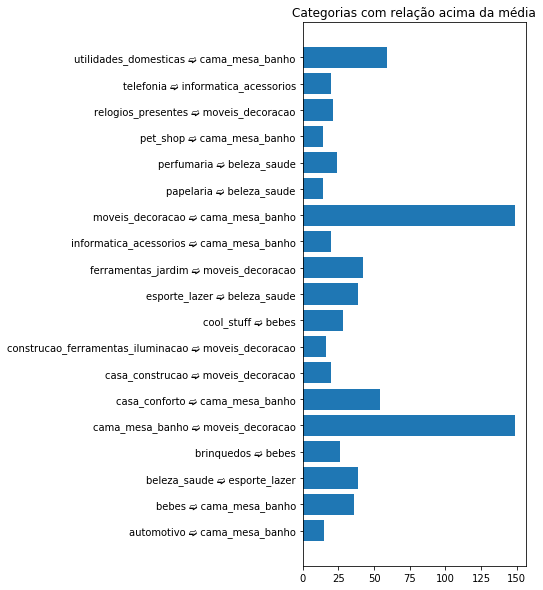

In [11]:
plt.figure(figsize=(4, 16))
above_average = relation_table[(relation_table['max'] > relation_table['max'].mean())]

above_avg_index = above_average.index.tolist()
above_avg_pointed = above_average['most_common'].values.tolist()

plt.figure(figsize=(4, 10))
plt.barh(
    [' ➫ '.join(cat) for cat in zip(above_avg_index, above_avg_pointed)],
    above_average['max'].values
)
plt.title('Categorias com relação acima da média')
plt.show()

In [12]:
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

low = category_sales_table.min().min()
high = category_sales_table.max().mean()


display(Markdown('### Vendas absolutas entre categorias'))
category_sales_table.to_csv("./category_sales_table.csv")
category_sales_table.style.apply(background_gradient, cmap='viridis', m=low, M=high)

### Vendas absolutas entre categorias

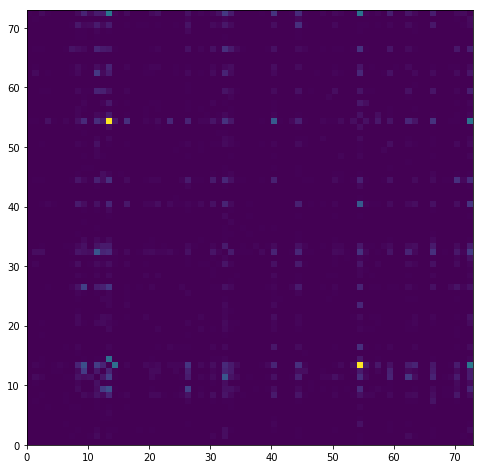

In [13]:
import matplotlib.colors as colors

plt.figure(figsize=(8, 8))
plt.pcolormesh(category_sales_table)
plt.show()

In [14]:
max_cat = category_sales_table.max().idxmax()
max_cat

'cama_mesa_banho'

In [15]:
max_dog = category_sales_table.loc[max_cat].idxmax()
max_dog

'moveis_decoracao'

A figura mostra um mapa de calor das compras entre categorias (cada linha e coluna é uma categoria). Cores mais claras indicam mais compras feitas por clientes em comum entre duas categorias.

É possível notar pela figura que algumas categorias têm relações com outras, mas a maioria não se relaciona. Isso é positivo para a relevância de um recomendador de conteúdo, por exemplo, visto que se todas as categorias se relacionassem da mesma forma não haveriam recomendações significativas, bem como se nenhuma tivesse relação não seria possível estabelecer padrões para recomendar produtos.

Os pontos mais claros no gráfico são da categoria `cama_mesa_banho` com `moveis_decoracao`, e apresentam uma quantidade de compras bem acima da média.

Se redefinirmos esses pontos para a média (para fins de observação apenas), o resto do gráfico apresenta valores mais nítidos.

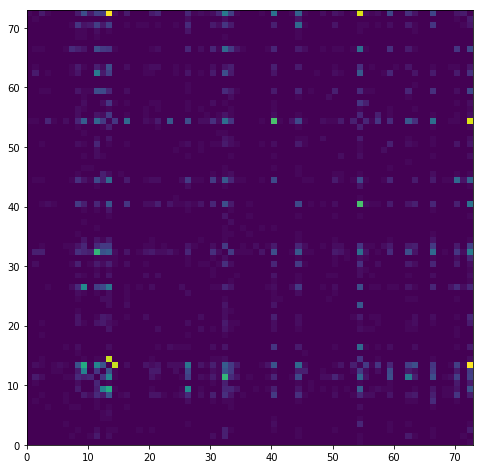

In [16]:
category_sales_table_ = category_sales_table.copy()
category_sales_table_.loc[max_cat, max_dog] = category_sales_table_.mean().mean()
category_sales_table_.loc[max_dog, max_cat] = category_sales_table_.mean().mean()

plt.figure(figsize=(8, 8))
plt.pcolormesh(category_sales_table_)
plt.show()

In [17]:
category_sales_table.max().std()

26.343865300388103

In [18]:
pointed_to = category_sales_table.sum()
pointed_to.sort_values(ascending=False).head(10)

cama_mesa_banho           566
moveis_decoracao          523
utilidades_domesticas     332
esporte_lazer             300
beleza_saude              274
informatica_acessorios    205
ferramentas_jardim        203
brinquedos                179
bebes                     177
relogios_presentes        177
dtype: int64

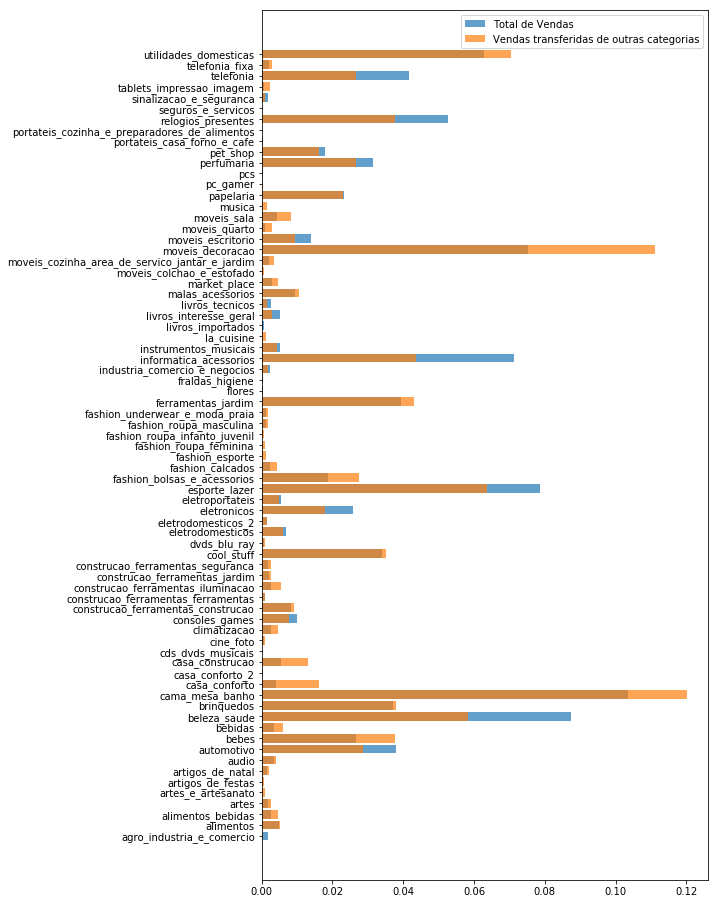

In [19]:
sales_by_category = orders_by_category.groupby('category').agg('count')['id']
sales_distribution = (sales_by_category / sales_by_category.sum()).sort_index()

pointed_to_distribution = (pointed_to / pointed_to.sum())

plt.figure(figsize=(8, 16))
plt.barh(categories, sales_distribution, alpha=0.7)
plt.barh(categories, pointed_to_distribution, alpha=0.7)
plt.legend(['Total de Vendas', 'Vendas transferidas de outras categorias'])
plt.show()

In [20]:
print(stats.kruskal(pointed_to_distribution, sales_distribution).pvalue * 100, '%', sep='')

45.8242603233784%


Hipotetizamos que a maior taxa em que algumas categorias são compradas pelo mesmo cliente que comprou de outras se deveria à maior popularidade delas. Aplicando o teste de Kruskal-Wallis, porém, obtemos um _pvalue_ de 45.8%, o que indica que esses dois valores provavelmente não seguem exatamente a mesma distribuição, apesar de não ser possível afirmar com precisão se são totalmente independentes.

Com isso, podemos concluir que é provável, sim, que seja possível fazer recomendações de categorias baseado em compras em outras categorias.